#Задание 2.


Demostrate consequences of No Free Lunch Theorem: every model of machine learning makes assumptions about dataset properties. If the assumption fails, model perfoms badly. If the assumption is met, model perfoms good.

For each of the tasks, described below:

1.   create a dataset to meet the description. For demonstration purposes, feature dimension size = 2
2.   train the models and evaluate accuracy. (with a training pipeline, described in the seminar)
3.   Show which model is better.
4.   Write what assumptions were used, and why model exibits such behavior.
5.   Plot dataset to demonstrate its properties. (Scatter plot, classes with different colors)


Tasks:

1. Create dataset for binary classification task (binary crossentropy), where k-NN perfoms worse than logistic regression

2. Create dataset for binary classification task (binary crossentropy), where logistic regression perfoms worse than k-NN

3. Create dataset for binary classification task (binary crossentropy), where k-NN with cosine distance perfoms better than k-NN with euclidean distance

! If there is no explanation, why one model perfoms better than the other on your dataset, the task does not count.
! if the training pipeline is not used, the task does not count.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [0]:
def model_pipline(model, X, y, hyper_params):
  '''
  Функция выполняет пайплайн с семинара: 
  обучение без регуляризации, затем с регуляризацией на валидационном датасете.
  Через GridSearchCV подбирается лучший вариант модели.
  
  Возвращает список mean-accuracy: 
  до регуляризации, лучшая оценка на валидации, оценка на тестовых данных
  '''
  scores = []
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  model.fit(X_train, y_train)
  scores.append(model.score(X_train, y_train))

  grid_search = GridSearchCV(model, cv=5, param_grid=hyper_params)
  grid_search.fit(X_train, y_train)
  scores.append(grid_search.best_score_)
  
  model = grid_search.best_estimator_
  scores.append(model.score(X_test, y_test))

  return scores

#Task №1. K-NN perfoms worse than logistic regression

Основная идея логистической регрессии заключается в том, что пространство исходных значений может быть разделено линейной границей (т.е. прямой) на две соответствующих классам области". У нас измерения два, поэтому достаточно просто прямой. 

KNN определяет класс объекта на основе рядом лежащих соседей. Поэтому для того, чтобы KNN работал хуже, чем логистическая регрессия, нам нужна выборка,которую легко разделить линейно, и которую сложнее разделить, опираясь на ближайшие точки. 

Попробуем функцию с минимальным маржином.


In [534]:
#Генерируем и нормализем выборку размера N
N = 100
x = np.array([[i for i in range(0,N//2)]
              + [i for i in range(N//2,N)]]).reshape(N,)
y = np.array([[-3*el-3 for el in range(0,N//2)] +
              [-3*el -2 for el in range(N//2,N)]]).reshape(N,)
x = x / np.linalg.norm(x)
y = y / np.linalg.norm(y)
x.shape, y.shape

((100,), (100,))

In [535]:
X_task1 = np.array([(x[i], y[i]) for i in range(0,N)]).reshape(N,2)
y_task1 = np.array([0 if i%2==0 else 1 for i in range(0,N)])
X_task1.shape, y_task1.shape

((100, 2), (100,))

Визуализируем выборку

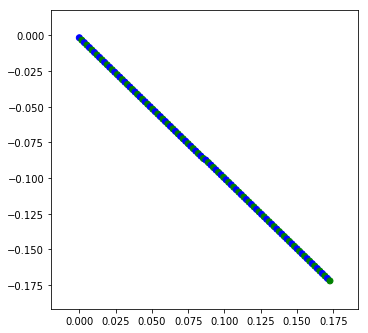

In [536]:
plt.figure(figsize=(5.5, 5.5))
plt.scatter([el[0] for el in X_task1],[el[1] for el in X_task1],
            c=['green' if el == 1 else 'blue' for el in y_task1])

Классы сливаются. Посмотрим теперь на наши модели на пайплайне.

In [537]:
#Задаем варианты гиперпараметров. Тут не все, т.к. некоторые конфликтуют друг с другом.
hyper_params = {
    'dual' : [True, False],
    'warm_start': [True, False],
    'solver' : ['liblinear']
}
scores = model_pipline(LogisticRegression(), X_task1, y_task1, hyper_params=hyper_params)
print('Train Acc {}; valid acc {}; test acc {}'.format(scores[0], scores[1], scores[2]))

Train Acc 0.5333333333333333; valid acc 0.5333333333333333; test acc 0.4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [538]:
hyper_params = {
    'n_neighbors': [i for i in range(1,10)],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
scores = model_pipline(KNeighborsClassifier(), X_task1, y_task1, hyper_params=hyper_params)
print('Train Acc {}; valid acc {}; test acc {}'.format(scores[0], scores[1], scores[2]))

Train Acc 0.6533333333333333; valid acc 0.41333333333333333; test acc 0.24


На тесте 0.44 у лог. регрессии и 0.24 у KNN. Логистическая модель превосходит KNN, т.к. для нее в месте скопления точек не имеют значения ближайшие соседи, а KNN может и хорошо определяет классы для удаленных точек, но в конкретно данной выборке будут проблемы. 

#Task №2. Logistic regression perfoms worse than K-NN

Итак, для логистической регрессии :чтобы все работало, точки исходных данных должны разделяться линейной границей на две  области. Давайте сделаем теперь наоборт - сгенерируем выборку, которую сложно (невозможно) разделить прямой на плоскости. А также улучшим задачу для KNN - сделаем выборку, обьекты одного класса которой будут находиться рядом друго с другом, в некоторых центрах классов. 

In [539]:
N = 300
X1 = np.random.randint(low=0,high=N//3, size=N//3)
X2 = np.random.randint(low=N//3, high=N//3*2, size=N//3)
X3 = np.random.randint(low=N//3*2, high=N, size=N//3)
X = np.append(X1,X2)
X = np.append(X, X3)
X = X / np.linalg.norm(X)

y = np.arange(0,N)
y = y / np.linalg.norm(y)

X_task2 = np.array([(X[i], y[i]) for i in range(0,N)])
X_task2.shape

(300, 2)

In [540]:
y_task2 = np.array([[1 for i in range(0,N//3+3)] 
                    + [0 for i in range(N//3+3,N//3*2+3)] 
                    + [1 for i in range(N//3*2+3,N)]])
y_task2 = y_task2.reshape(N,)
y_task2.shape

(300,)

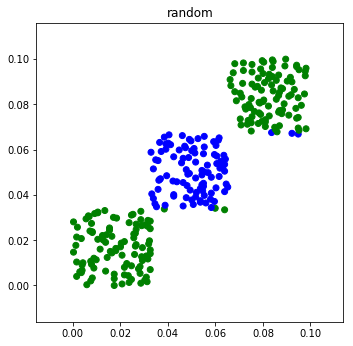

In [541]:
plt.figure(figsize=(5.5, 5.5))
plt.scatter([el[0] for el in X_task2],[el[1] for el in X_task2],
            c=['green' if el == 1 else 'blue' for el in y_task2])
plt.title('random')

In [542]:
hyper_params = {
    'dual' : [True, False],
    'warm_start': [True, False],
    'solver' : ['liblinear']
}
scores = model_pipline(LogisticRegression(), X_task2, y_task2, hyper_params=hyper_params)
print('Train Acc {}; valid acc {}; test acc {}'.format(scores[0], scores[1], scores[2]))

Train Acc 0.6577777777777778; valid acc 0.6577777777777778; test acc 0.6933333333333334


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [543]:
hyper_params = {
    'n_neighbors': [i for i in range(1,10)],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
scores = model_pipline(KNeighborsClassifier(), X_task2, y_task2, hyper_params=hyper_params)
print('Train Acc {}; valid acc {}; test acc {}'.format(scores[0], scores[1], scores[2]))

Train Acc 0.9733333333333334; valid acc 0.9822222222222222; test acc 0.9866666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Как хорошо видно из визуализации, для логистической регрессии нельзя здесь построить прямую, отделяющую два класса. Для KNN же даннные идеальны: ярко выражены центры классов, несмотря на небольшую зашумленность, модель показывает 1.0 на тестовых данных (да, в реальности такого не будет, да, это полностью игрушечные данные).

#Task №3. k-NN with cosine distance perfoms better than k-NN with euclidean distance

Источник (помимо семинарских тетрадок) : https://cmry.github.io/notes/euclidean-v-cosine

Косинусная мера близости использует направления векторов (игнорируя длины векторов), евклидова метрика - расстояния между векторами. И если мы хотим, чтобы K-NN cosine показывала результат лучше чем K-NN euclodean, то наши данные должны быть: 

- близко расположены друг к другу/наоборот, можно попытаться добиться равноудаленности как-нибудь(расстояние между точками не должно быть определяющим фактором при классификации). 

Давайте сделаем все точки одного класса на одной прямой, а остальные разложим по одну сторону от этой прямой рандомно. 

In [556]:
N = 100
x = np.arange(0,N//2)
X1 = np.array([(x[i], 0) for i in range(0,N//2)])
X2 = np.array([(x[i], np.random.randint(1, 10, 1)[0]) for i in range(0, N//2)])
X_task3 = np.append(X1,X2, axis=0)

(50, 2)
(50, 2)


((100, 2), array([2, 0]))

In [562]:
y_task3 = np.array([0 if i < N//2 else 1 for i in range(N)])
y_task3.shape

(100,)

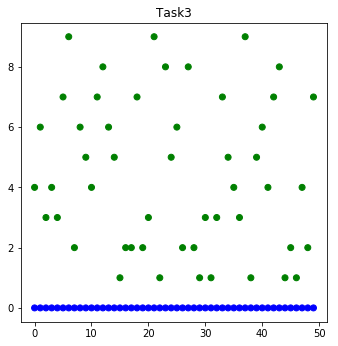

In [563]:
plt.figure(figsize=(5.5, 5.5))
plt.scatter([el[0] for el in X_task3],[el[1] for el in X_task3],
            c=['green' if el == 1 else 'blue' for el in y_task3])
plt.title('Task3')

In [566]:
hyper_params = {
    'n_neighbors': [i for i in range(1,10)],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
scores = model_pipline(KNeighborsClassifier(metric='euclidean'), X_task3, y_task3, hyper_params=hyper_params)
print('Train Acc {}; valid acc {}; test acc {}'.format(scores[0], scores[1], scores[2]))

Train Acc 0.9333333333333333; valid acc 0.8666666666666667; test acc 0.92


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [569]:
hyper_params = {
    'n_neighbors': [i for i in range(1,10)],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'brute']
}
scores = model_pipline(KNeighborsClassifier(metric='cosine'), X_task3, y_task3, hyper_params=hyper_params)
print('Train Acc {}; valid acc {}; test acc {}'.format(scores[0], scores[1], scores[2]))

Train Acc 1.0; valid acc 1.0; test acc 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
